## Notebook showing a hybrid stacker bagger
#### For validation:
1) Each base learner is trained on a subset of the items, split by some category
2) Each base learner is then made to predict on the whole validation set to get validation score
3) these validation scores used to train metamodel

#### For training:
1) Each learner retrained on the whole subset of their items

#### For testing:
1) Each learner predicts on whole training set, predictions are then passed to metamodel which makes final predictions.

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from rankers.Stacker import Stacker
from rankers.Ranker import Ranker
import numpy as np
import pandas as pd
from Evaluations import get_evaluation_plots


In [2]:
#10 weeks in total for training, validation is done on last 5 weeks
nr_training_weeks = 10
nr_validation_weeks = 5
nr_rankers = 3

In [3]:
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False, nr_training_weeks=nr_training_weeks)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1


In [4]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [5]:
test_X = test#[columns_to_use]

In [6]:
base_rankers = [LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
) for i in range(nr_rankers)]

In [7]:
stacker = Stacker(base_rankers, Ranker(AdaBoostClassifier()), use_groups=[True for i in range(nr_rankers)], split_category="garment_group_no")

In [8]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

Category 'garment_group_no' splits: [array([1014, 1017, 1020, 1005, 1009, 1010, 1007], dtype=int32), array([1018, 1008, 1021, 1003, 1025, 1013, 1019], dtype=int32), array([1001, 1002, 1006, 1016, 1023, 1012, 1011], dtype=int32)]
computing validation predictions for each of the base rankers...
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.108194
[LightGBM] [Debug] init for col-wise cost 0.000037 seconds, init for row-wise cost 0.165572 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 2586551, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: spars

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.112108
[LightGBM] [Debug] init for col-wise cost 0.000055 seconds, init for row-wise cost 0.159378 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 2542882, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.833481
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.262775
[LightGBM] [Debug] init for col-wise cost 0.047575 seconds, init for row-wise 

In [9]:
test['stacker_bagger'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   1.   1. ]
 [11.   4.   7.5]
 [ 2.5  7.5  7.5]
 ...
 [ 6.   7.5  7.5]
 [ 6.   5.5  7.5]
 [11.   5.5  7.5]]


In [10]:
#same as plain Random Subspaces
test['unweighted'] = stacker.predict(test_X, columns_to_use, weighting=None)

Predicting with None weighting


In [11]:
test['MRR_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MRR")

Predicting with MRR weighting


In [12]:
test['MAPk_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MAPk")

Predicting with MAPk weighting


In [13]:
for i in range(len(base_rankers)):
    test[f'ranker{i}'] = base_rankers[i].predict(test_X[columns_to_use])

In [14]:
pred_cols =['stacker_bagger', 'unweighted', 'MRR_weighted', 'MAPk_weighted'] + [f"ranker{i}" for i in range(len(base_rankers))]

In [15]:
stacker.ranker_weights

{'MRR': [0.924433783221612, 0.9188169690879325, 0.9024816811827687],
 'MAPk': [0.8610451935278568, 0.8518223711586591, 0.8407014002233616],
 'Pk': [0.0, 0.0, 0.0]}

In [16]:
#checking predicitons arent all exactly the same value
len(np.unique(test['stacker_bagger']))

1350

In [17]:
train_no_val = train[(train.week >= train.week.min()+nr_validation_weeks)]

In [18]:
len(np.unique(test['ranker2']))

31

In [19]:
test['stacker_bagger']

11557594    6566104.5
11557595    3412242.0
11557596    5484486.0
11557597    4608441.0
11557598    4608441.0
              ...    
18215795    2515166.0
18215796    3999525.0
18215797    4823753.0
18215798    4964156.0
18215799    3754969.0
Name: stacker_bagger, Length: 6658206, dtype: float64

In [20]:
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,fashion_news_frequency,age,postal_code,ranker0,ranker1,ranker2,stacker_bagger,unweighted,MRR_weighted,MAPk_weighted
11557594,2020-09-03,28847241659200,925246001,0.128797,2,104,0.0,999.0,925246,25454,...,1,21,57896,0.176882,0.184088,0.112495,6566104.5,6641787.5,6641835.5,6641835.5
11557595,2020-07-14,28847241659200,909370001,0.032947,1,104,0.0,1.0,909370,23319,...,1,21,57896,-0.194596,-0.172399,-0.196292,3412242.0,3616058.0,3616058.0,3616058.0
11557596,2020-07-14,28847241659200,865799006,0.033340,1,104,0.0,2.0,865799,18468,...,1,21,57896,-0.186928,-0.189205,-0.196292,5484486.0,4876102.5,4876102.5,4876102.5
11557597,2020-07-14,28847241659200,918522001,0.041416,1,104,0.0,3.0,918522,26372,...,1,21,57896,-0.194596,-0.150223,-0.196292,4608441.0,3785803.0,3785803.0,3785803.0
11557598,2020-07-14,28847241659200,924243001,0.041549,1,104,0.0,4.0,924243,19190,...,1,21,57896,-0.194596,-0.138928,-0.196292,4608441.0,3955548.0,3955548.0,3955548.0


Evaluation for stacker_bagger
####################

MAP@12 (all customers):             0.0011683897043368544
MAP@12 (only purchasing customers): 0.02323737832767132

MRR (all customers):                0.002214255281446497
MRR (only purchasing customers):    0.04403795026439413



Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011604022620039245
MAP@12 (only purchasing customers): 0.023078521040011374

MRR (all customers):                0.0021895839093065005
MRR (only purchasing customers):    0.0435472766422697



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.001160767426075341
MAP@12 (only purchasing customers): 0.023085783561794717

MRR (all customers):                0.0021906170324150183
MRR (only purchasing customers):    0.04356782378715002



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.0011606337992489054
MAP@12 (only purchasing customers): 0.02308312

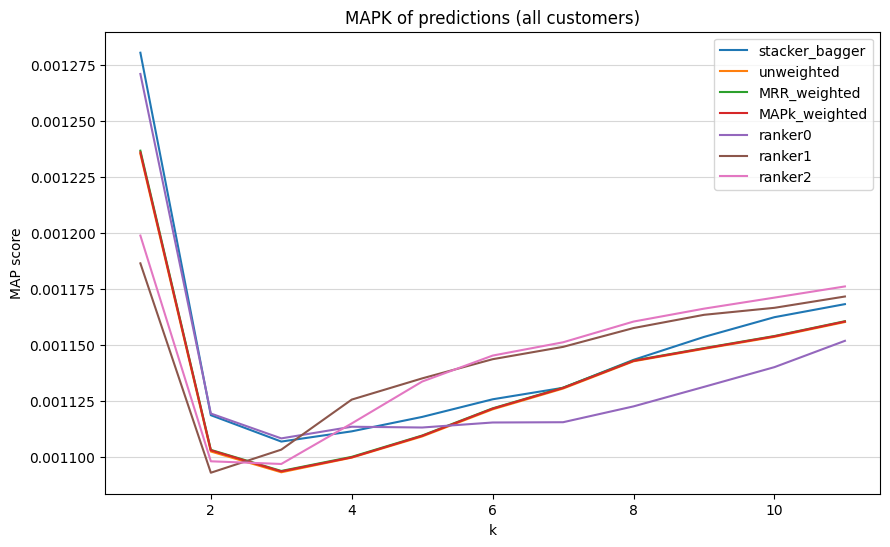

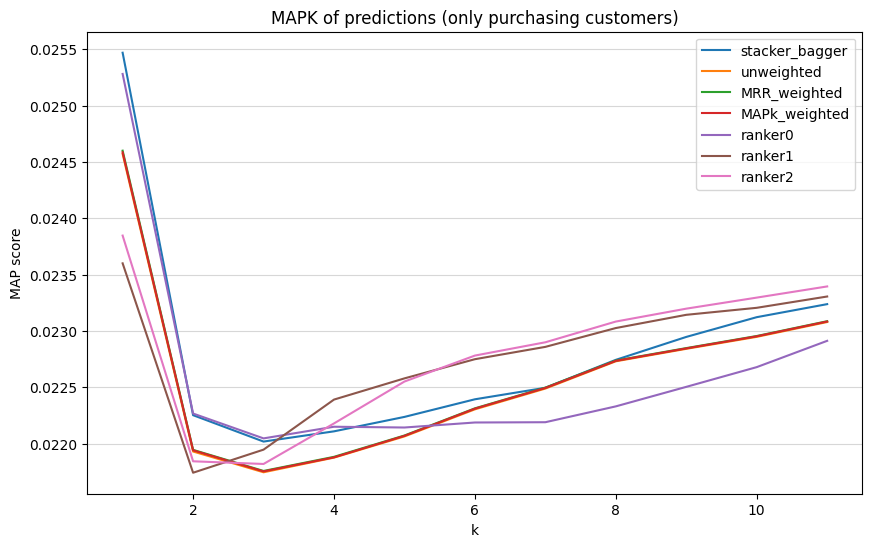

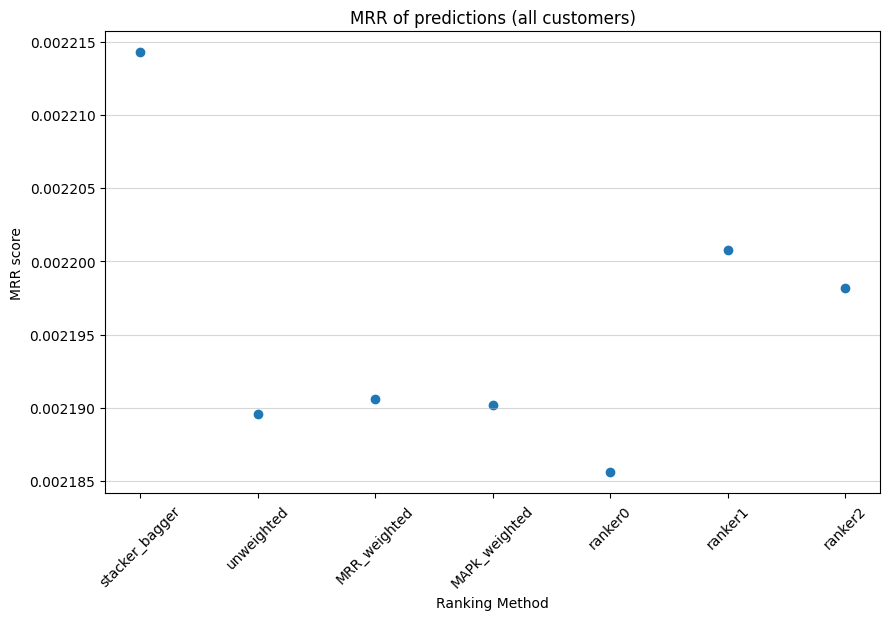

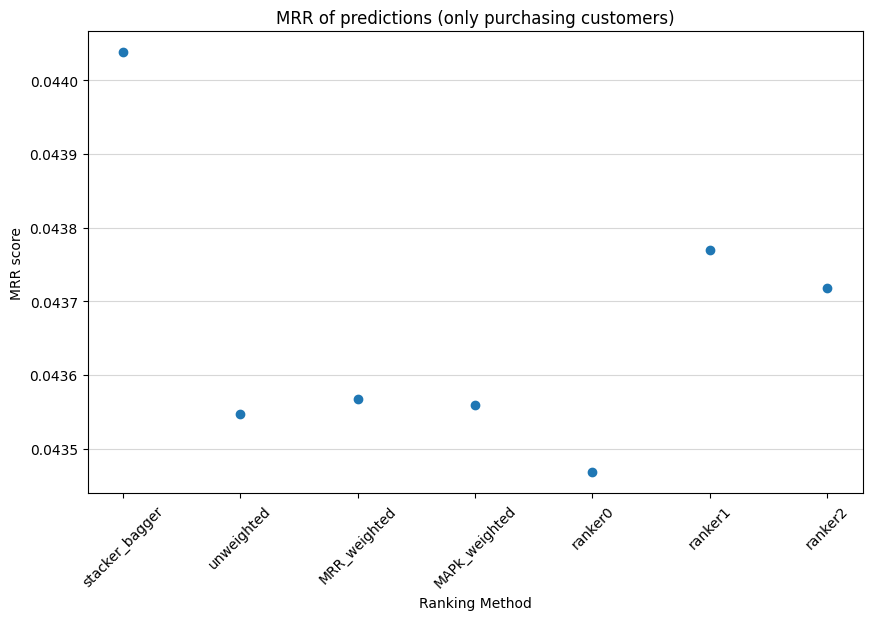

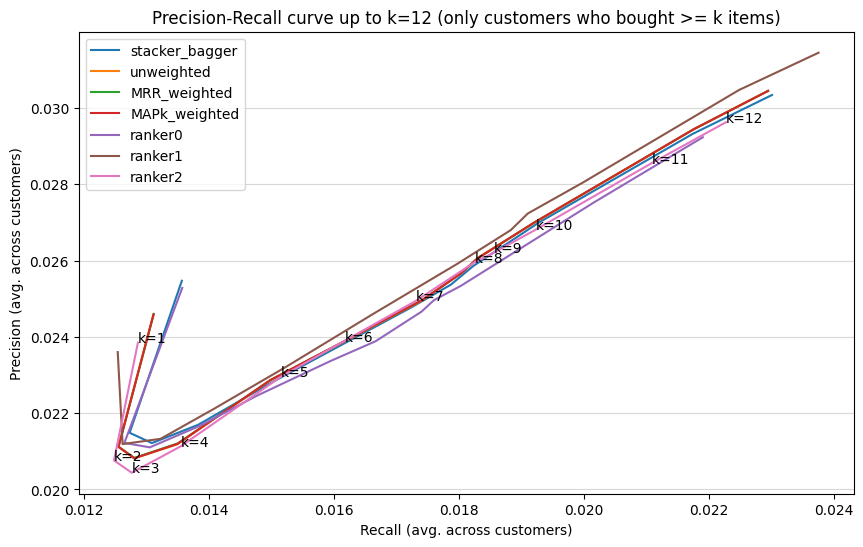

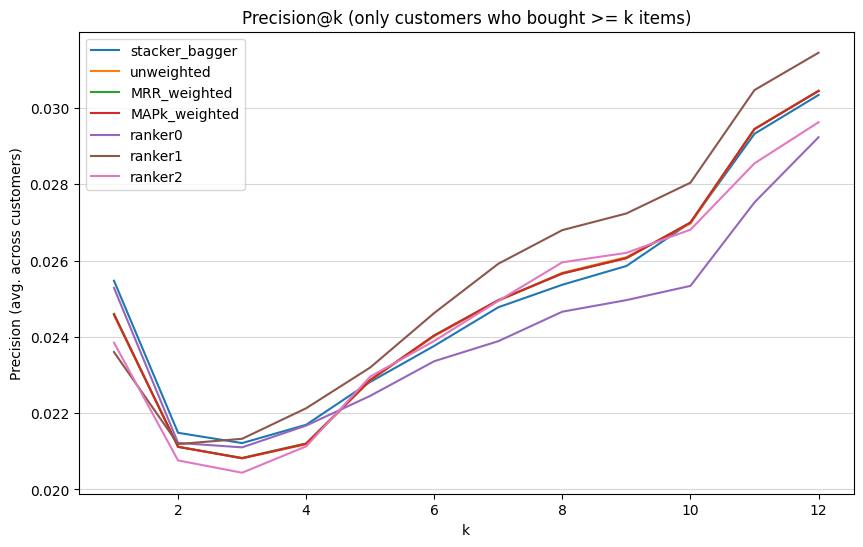

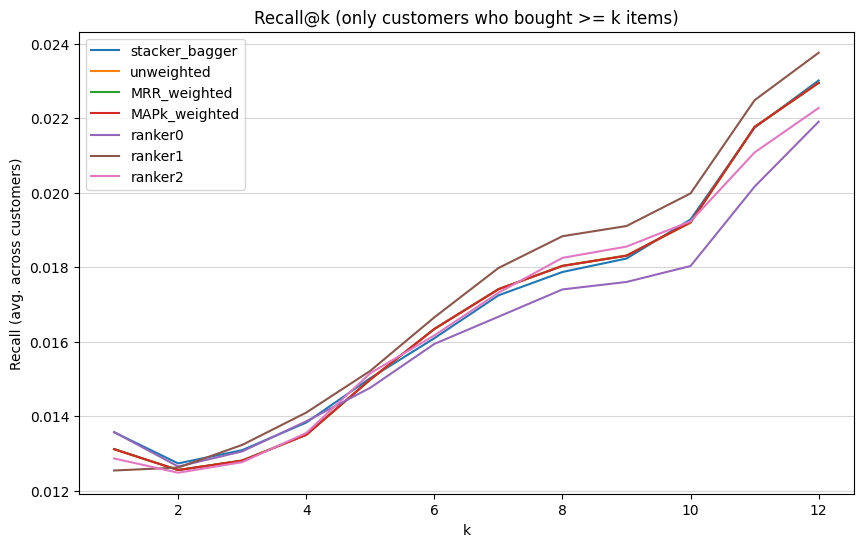

({'stacker_bagger': [0.0012806309129870697,
   0.0011188209740666773,
   0.0011070375175537062,
   0.0011116031007902603,
   0.0011180463434031264,
   0.0011259100796739828,
   0.001131046489938123,
   0.0011435210748099,
   0.0011537541725075257,
   0.001162568134347407,
   0.0011683897043368544],
  'unweighted': [0.0012354407498651584,
   0.001102603536494701,
   0.001093330644599613,
   0.0010998651988772105,
   0.0011093320521355192,
   0.0011214252799279548,
   0.0011307018492465288,
   0.001142871946552641,
   0.0011484352518535217,
   0.001153786260667288,
   0.0011604022620039245],
  'MRR_weighted': [0.0012368984970626395,
   0.0011033324100934417,
   0.0010939177927763765,
   0.0011002195124321535,
   0.0011097434607890305,
   0.0011218686780338554,
   0.0011311118199861378,
   0.0011432066282442848,
   0.001148762610261598,
   0.0011541595914599761,
   0.001160767426075341],
  'MAPk_weighted': [0.0012361696234638989,
   0.0011031501916937564,
   0.0010937153278878372,
   0.00

In [21]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

### Testing with different categories to show stacker works with different categories

In [22]:
#test spliting on different categories to see if different category splits may improve ranker
#test.rename(columns={'stacker_bagger': 'garment_group_split'})
test['garment_group_split'] = test['stacker_bagger']
categories_to_test = ['product_type_no', 'graphical_appearance_no', 'perceived_colour_value_id', 'department_no']

In [23]:
for cat in categories_to_test:
    base_rankers = [LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        boosting_type="dart",
        n_estimators=1,
        importance_type='gain',
        verbose=10
        ) for i in range(nr_rankers)]
    stacker = Stacker(base_rankers, Ranker(AdaBoostClassifier()), use_groups=[True for i in range(nr_rankers)], split_category=cat)
    stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)
    test[cat+"_split"] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Category 'product_type_no' splits: [array([100, 295, 271, 510, 231, 276, 509,  90, 299, 523, 262, 296, 521,
        91, 504, 467, 252, 476, 511,  77, 494,  75,  67, 493, 289, 529,
       255, 285, 263, 499,  87, 475, 270, 259,  88,  69, 155,  76, 306,
       307, 496, 465], dtype=int32), array([ 86, 277,  93,  49,  82, 156,  68, 256,  70, 498, 300, 161, 303,
       264,  89,  94,  -1, 245, 298,  81, 492,  85,  59,  60, 287, 495,
       532, 258, 286, 144, 761, 254, 273, 304, 302,  71,  74, 470, 512,
        66, 257], dtype=int32), array([525, 515, 274,  73, 762, 508, 326, 260,  92, 468, 288, 491, 275,
       477, 297, 267, 293,  83,  80, 503, 253,  57, 389, 308,  78, 230,
        96, 283, 268, 261,  84, 489,  98, 291, 272, 102, 305,  79, 265,
        72,  95], dtype=int32)]
computing validation predictions for each of the base rankers...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.824642
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.879911
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.226991
[LightGBM] [Debug] init for col-wise cost 0.027932 seconds, init for row-wise cost 0.106590 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 1559588, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.114893
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise 

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.810070
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.211494
[LightGBM] [Debug] init for col-wise cost 0.076225 seconds, init for row-wise cost 0.248620 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 3851250, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.118555
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.118172
[LightGBM] [Debug] init for col-wise cost 0.000016 seconds, init for row-wise cost 0.123932 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 2033473, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.854787
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.316247
[LightGBM] [Debug] init for col-wise cost 0.071963 seconds, init for row-wise

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.783544
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.205454
[LightGBM] [Debug] init for col-wise cost 0.050625 seconds, init for row-wise cost 0.155744 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 2623766, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.858847
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.149894

In [24]:
len(train.index)

11557594

In [25]:
train["ranker0"].isna().sum()

6432764

In [26]:
pred_cols = [c+"_split" for c in categories_to_test] + ["garment_group_split"]

In [27]:
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,ranker2,stacker_bagger,unweighted,MRR_weighted,MAPk_weighted,garment_group_split,product_type_no_split,graphical_appearance_no_split,perceived_colour_value_id_split,department_no_split
11557594,2020-09-03,28847241659200,925246001,0.128797,2,104,0.0,999.0,925246,25454,...,1.0,6566104.5,6641787.5,6641835.5,6641835.5,6566104.5,6569427.0,6517679.0,6377014.0,6506162.0
11557595,2020-07-14,28847241659200,909370001,0.032947,1,104,0.0,1.0,909370,23319,...,7.5,3412242.0,3616058.0,3616058.0,3616058.0,3412242.0,5337223.5,4808748.5,1198691.0,2873150.0
11557596,2020-07-14,28847241659200,865799006,0.033340,1,104,0.0,2.0,865799,18468,...,7.5,5484486.0,4876102.5,4876102.5,4876102.5,5484486.0,1811489.0,2302047.5,4609851.0,4664088.0
11557597,2020-07-14,28847241659200,918522001,0.041416,1,104,0.0,3.0,918522,26372,...,7.5,4608441.0,3785803.0,3785803.0,3785803.0,4608441.0,3748180.5,4808748.5,4846661.0,5283298.0
11557598,2020-07-14,28847241659200,924243001,0.041549,1,104,0.0,4.0,924243,19190,...,7.5,4608441.0,3955548.0,3955548.0,3955548.0,4608441.0,4169234.0,4808748.5,2365026.0,5283298.0


Evaluation for product_type_no_split
####################

MAP@12 (all customers):             0.0011668884382248584
MAP@12 (only purchasing customers): 0.02320752057688363

MRR (all customers):                0.002204693890232323
MRR (only purchasing customers):    0.04384778968341851



Evaluation for graphical_appearance_no_split
####################

MAP@12 (all customers):             0.001175952635568796
MAP@12 (only purchasing customers): 0.023387792777277008

MRR (all customers):                0.0022003580652030378
MRR (only purchasing customers):    0.043761557147994665



Evaluation for perceived_colour_value_id_split
####################

MAP@12 (all customers):             0.001119230832167383
MAP@12 (only purchasing customers): 0.0222596880018121

MRR (all customers):                0.002157992182099683
MRR (only purchasing customers):    0.04291896836943528



Evaluation for department_no_split
####################

MAP@12 (all customers):             0.00116882615640518

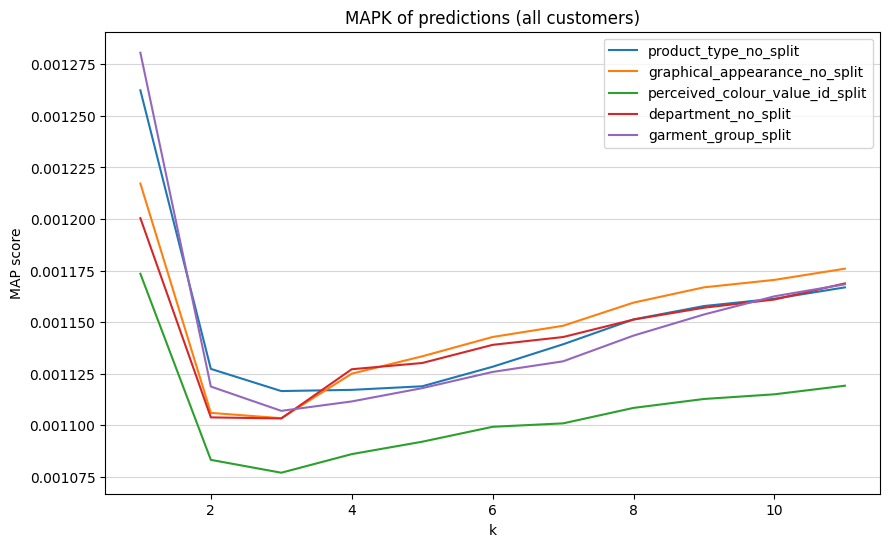

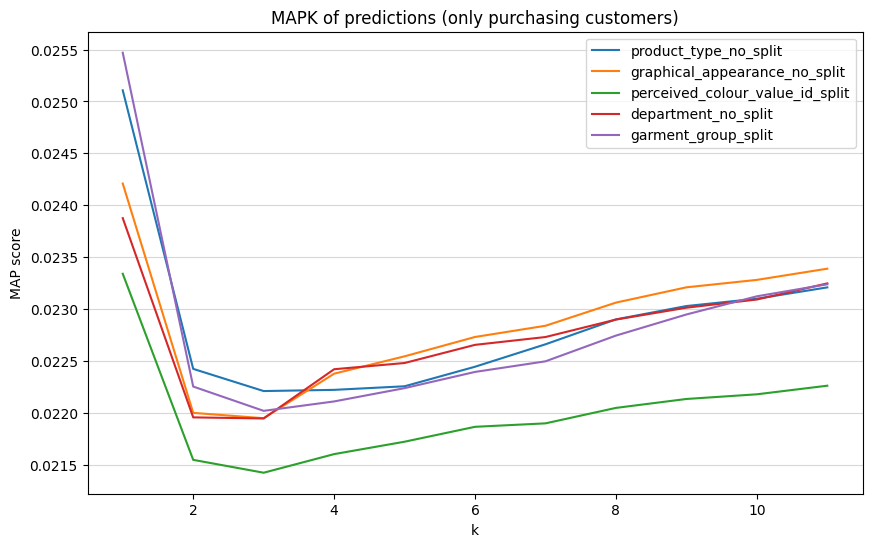

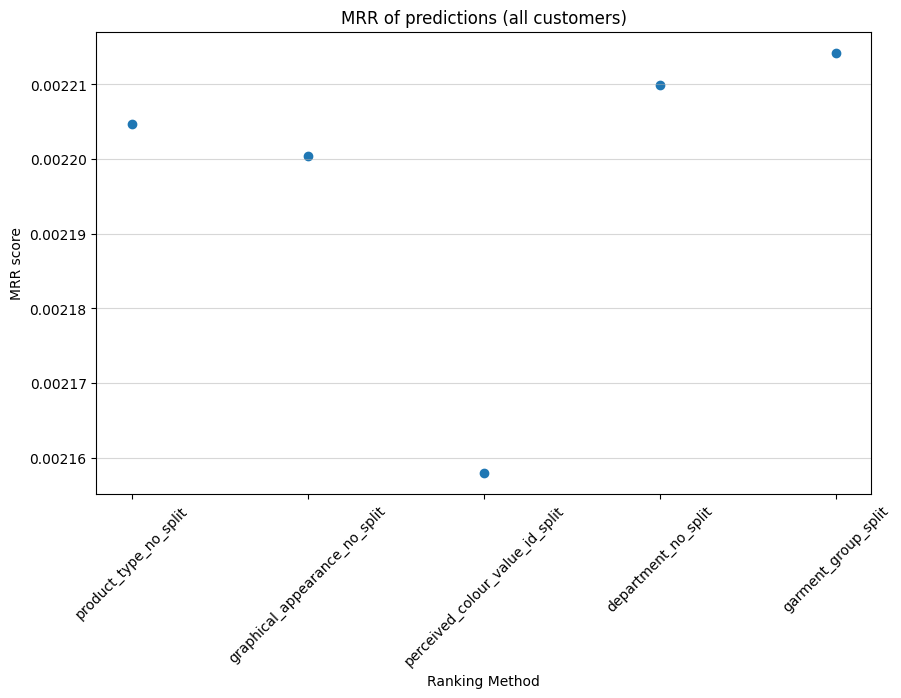

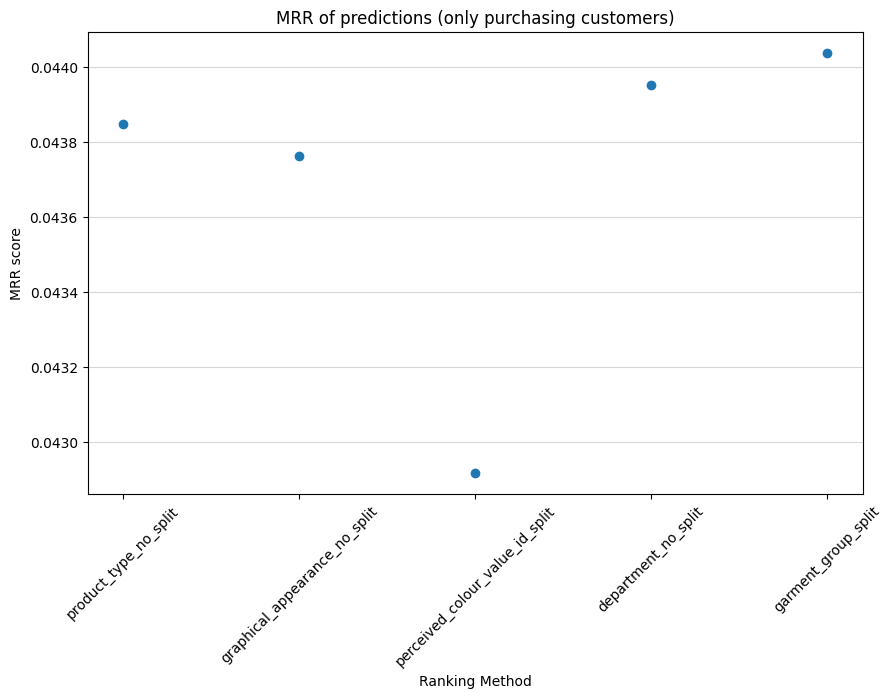

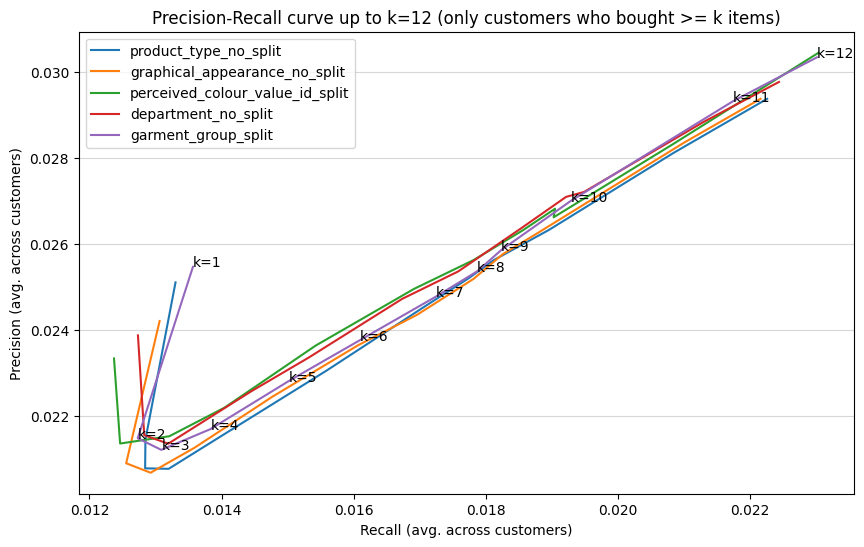

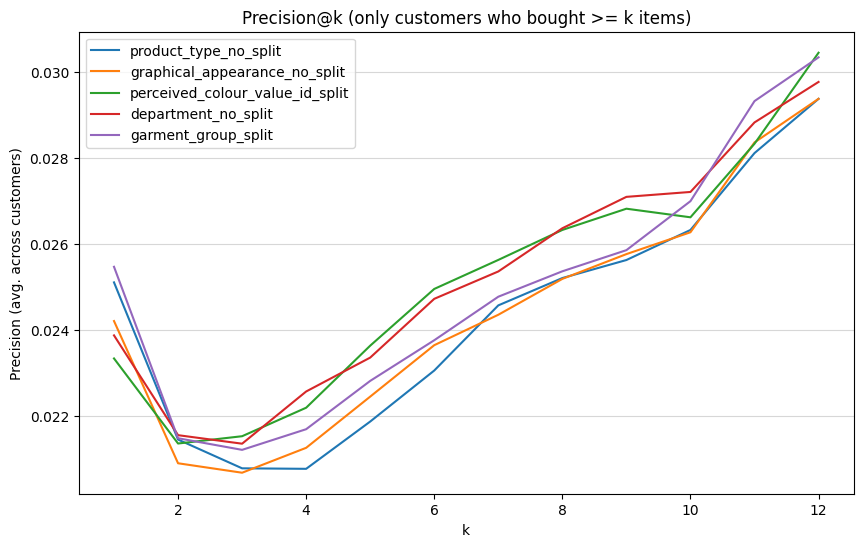

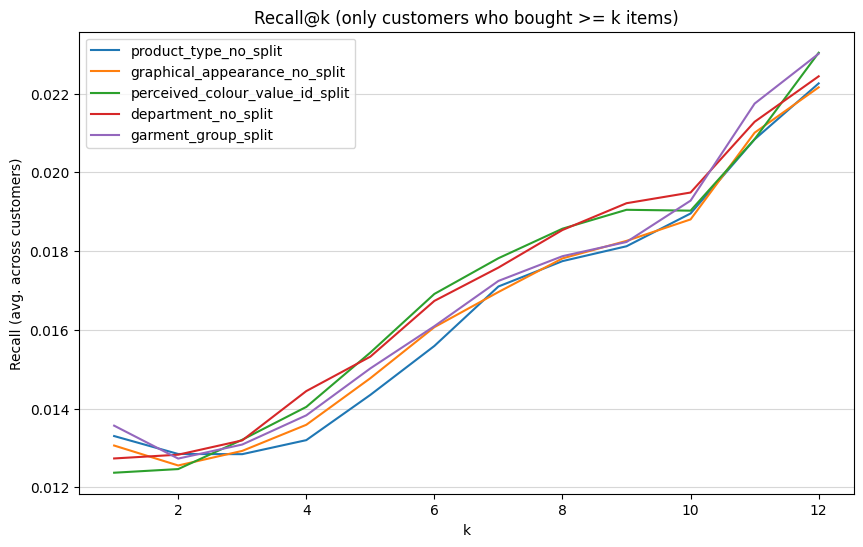

({'product_type_no_split': [0.001262409073018557,
   0.0011273852388518782,
   0.0011166343532704552,
   0.0011172164398250057,
   0.0011189511589900075,
   0.0011284224664758632,
   0.0011393038799313456,
   0.0011513729978743,
   0.0011578429039881826,
   0.0011614022624385255,
   0.0011668884382248584],
  'graphical_appearance_no_split': [0.0012172189098966458,
   0.0011060656860887184,
   0.0011034741355154187,
   0.0011250619542558932,
   0.0011334725481906924,
   0.0011428503168980427,
   0.0011482819540251659,
   0.00115950702580434,
   0.0011669161801945004,
   0.0011705229957719714,
   0.001175952635568796],
  'perceived_colour_value_id_split': [0.0011734864939722154,
   0.0010832883861280776,
   0.0010770524675610756,
   0.0010860722783454897,
   0.0010920800189831088,
   0.0010993096352230592,
   0.0011009794747211263,
   0.001108472772554845,
   0.0011127994030341575,
   0.0011150622663226926,
   0.001119230832167383],
  'department_no_split': [0.001200454817125614,
   0.00

: 

In [28]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)